<a href="https://colab.research.google.com/github/thulasi-bikku/Classification/blob/main/Organic_Comparative_With_and_Without_Binning_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objectives:Here we have considered Organic Dataset (Sellmeier augmentation also improves the accuracy significantly) and applied Random Forest using Binning (Divided entire dataset into 10 equal parts) and without Binning. 

### Getting Started:
- Colab notebooks consist of text cells (like this one) and program code cells, like the one shown below. Code cells are executed by typing the Cmd+Enter keys (or Ctrl-Enter). You can also execute a code cell by mousing over the [ ] symbol in the upper left hand side of the code cell---when you hover over it it will turn into a "play" button, and clicking the play button will execute the code cell. You can find other options for executing groups of cells in the "Runtime" menu above.

- Start by executing the code cell below (the one that begins with the line import pandas as pd). This loads ("imports") the required software modules that will be used in the assignment.
## Loading Python Libraries

In [4]:
#load the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from scipy import stats
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Take a moment to look at this code block:
- import loads a module
- import ... as allows you to assign a short alias to the module
- from ... import loads a small portion of a module
- observe that the import, as and from keywords are color coded purple.
indicates a comment (observe that all of the text following the # is color coded green). This text is not interpreted by the computer, and its goal is to provide the human with some information about what is happening.<BR><BR>
What do each of these program modules do? You can think of them as being like a library of books that accomplish program tasks. In general, they can be quite complicated. In most cases, you will never learn all of the functionality of a module, and will have to use the documentation to help you determine the relevant parts for solving your problem. It is useful to have a general sense of the types of tasks that each of modules do, so that you can find the appropriate functionality.

- `pandas` is a library for handling datasets
- `numpy` and `scipy` are libraries for mathematical and scientific computing
- `matplotlib` and `plotly` are libraries for data visualization
- `sklearn` and `imblearn` are libraries for machine learning

Importing file:

In [5]:
from google.colab import files
uploaded = files.upload()

Saving Organic_full.xlsx to Organic_full.xlsx


In [6]:
import io
df_full = pd.read_excel(io.BytesIO(uploaded['Organic_full.xlsx']))
df_full.head()

,shelf,book,page,λ,n,k
0,organic,benzene,Myers,3.378610,1.482600,0.000796
1,organic,ethylene_glycol,Sani,0.383070,1.447620,0.000000
2,organic,ethylene_glycol,Sani-formula,0.324391,1.459061,0.000000
3,organic,polydimethylsiloxane,Schneider-RTV615,0.612752,1.429758,0.000000
4,organic,poly(N-isopropylacrylamide),Brasse,0.784758,1.497342,0.001875


In [7]:
# Creating a copy in case we make any permanent changes and want to start from beginning.
df = df_full.copy()
df.shape

(452069, 6)

In [8]:
df.sample(4)

,shelf,book,page,λ,n,k
69204,organic,polystyren,Myers,1.430240,1.553720,0.000055
158986,organic,styrene,Myers,3.963510,1.515170,0.000141
187991,organic,dimethyl_sulfoxide,Kozma,0.349592,1.511092,0.000000
298419,organic,ethanol,Myers,1.704450,1.346660,0.000104


## Exploring the dataset

In [9]:
df.head(3)

,shelf,book,page,λ,n,k
0,organic,benzene,Myers,3.378610,1.482600,0.000796
1,organic,ethylene_glycol,Sani,0.383070,1.447620,0.000000
2,organic,ethylene_glycol,Sani-formula,0.324391,1.459061,0.000000


In [10]:
# Size of the dataframe
df.shape

(452069, 6)

In [11]:
# Investigating all the elements within each feature
for column in df:
    unique_vals = np.unique(df[column].astype(str))
    nr_values = len(unique_vals)
    
    if nr_values < 36:
        print('The number of values for feature -  {} : {} -- {}'.format(column, nr_values, unique_vals))
    else:
        print('The number of values for feature {} : {}'.format(column, nr_values))

The number of values for feature -  shelf : 1 -- ['organic']
The number of values for feature book : 61
The number of values for feature page : 59
The number of values for feature λ : 139213
The number of values for feature n : 241402
The number of values for feature k : 195870


61 different categories. We need to predict the right one, given the features.

In [12]:
# Dropping the column 'Shelf' and 'Page' as they are not relevent for the training and testing
# Renaming wavelength from 'λ' to 'wl' as lambda('λ') is harder to type.
df.drop(['shelf', 'page'], axis = 1, inplace= True)
df.rename(columns= {'λ': 'wl'}, inplace= True)

In [13]:
# Replacing NaN, k values with '0'
df['k'].fillna(0, inplace = True)

# dropping n values that are null 
df.dropna(axis=0, inplace=True)
df.shape

(445225, 4)

Down from `452069` number of rows to `445225`

## Shuffling the dataset

In [14]:
display(df.head())
df = df.sample(frac=1).reset_index(drop= True)
df.head()

,book,wl,n,k
0,benzene,3.378610,1.482600,0.000796
1,ethylene_glycol,0.383070,1.447620,0.000000
2,ethylene_glycol,0.324391,1.459061,0.000000
3,polydimethylsiloxane,0.612752,1.429758,0.000000
4,poly(N-isopropylacrylamide),0.784758,1.497342,0.001875


,book,wl,n,k
0,trichlorobenzene,4.492320,1.543240,0.000041
1,toluene,1.293740,1.474590,0.000009
2,ethanol,4.328990,1.360250,0.000393
3,nitrobenzene,0.653261,1.545446,0.000000
4,polystyren,2.052170,1.553060,0.000069


In [15]:
df.sample(2)

,book,wl,n,k
13165,styrene,1.34927,1.51625,0.00003
113430,dimethyl_methylphosphonate,1.56467,1.40032,0.00003


In [16]:
# Classfying the wavelengths to different catagories,based on the range of Wavelength
df['wl_binned'] = pd.cut(df['wl'], [0,0.4,0.75,1.5,4.0, np.inf], labels= ['UV', 'Visible', 'Near_IR', 'IR', 'Far_IR'])
df.sample(3)

,book,wl,n,k,wl_binned
34423,dimethyl_methylphosphonate,4.447830,1.386610,0.000643,Far_IR
354355,Methanol,16.767600,1.390950,0.061416,Far_IR
401642,polydimethylsiloxane,0.426891,1.430818,0.000000,Visible


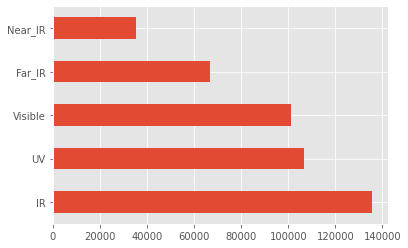

In [17]:
# To check the number of wavelength of each category type
df.wl_binned.value_counts().plot(kind= 'barh')

In [18]:
df.shape

(445225, 5)

## Splitting the Raw Data
*Creating Input features (attributes) and Target Vectors for Training and testing the ML model.*

In [19]:
x = df.drop('book', axis=1) # Input features (attributes)
y = df['book']   # Taget Vector

print('X shape: {}'.format(np.shape(x)))
print('Y shape: {}'.format(np.shape(y)))

X shape: (445225, 4)
Y shape: (445225,)


*`75%` data is for training and `25%` data is for testing.*

In [20]:
#split the data for training and testing
from sklearn.metrics import accuracy_score,classification_report
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,random_state=42)

In [21]:
print('Length of x_test : {}\nLength of y_test : {}\nLength of x_train : {}\nLength of y_train : {}'.format(len(x_test),  len(y_test), len(x_train), len(y_train)))

Length of x_test : 111307
Length of y_test : 111307
Length of x_train : 333918
Length of y_train : 333918


### Random Forest Binning

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [23]:
df.sample()

,book,wl,n,k,wl_binned
8259,polystyren,3.44082,1.5749,0.026736,IR


In [24]:
numeric_features = ['wl','n','k']

In [25]:
#preprocessing and training pipeline with binning

numeric_transformer = Pipeline(steps=[
                                      ('scaler', StandardScaler()),
                                      ('binning',KBinsDiscretizer(n_bins=10,encode='onehot')) #apply binning in 10 groups and one hot encode them
                                      ])

preprocessor = ColumnTransformer(
    transformers=[
                  ('numeric', numeric_transformer, numeric_features)   #apply the transformation
                  ]) 

pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',RandomForestClassifier())
           ])

In [26]:
#model
rf_model = pipeline.fit(x_train, y_train)
print (rf_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('binning',
                                                                   KBinsDiscretizer(n_bins=10))]),
                                                  ['wl', 'n', 'k'])])),
                ('regressor', RandomForestClassifier())])


In [27]:
# You can check the training and testing accuracy down below of the df1 dataset
print(f'Training accuracy {rf_model.score(x_train,y_train)}')
print(f'Test accuracy {rf_model.score(x_test,y_test)}')

Training accuracy 0.5290400637282207
Test accuracy 0.5289873952222233


In [28]:
#updated
# You can check the training and testing accuracy down below of the df1 dataset
print(f'Training accuracy {rf_model.score(x_train,y_train)}')
print(f'Test accuracy {rf_model.score(x_test,y_test)}')

Training accuracy 0.5290400637282207
Test accuracy 0.5289873952222233


### Cross Validation

In [29]:
from sklearn.model_selection import cross_val_score
cv_four = cross_val_score(rf_model, x, y, cv = 4, scoring = 'accuracy')
print(cv_four)
print('Mean:',cv_four.mean())

[0.5306854  0.52945034 0.52872262 0.52872262]
Mean: 0.529395246695143


In [30]:
from sklearn.model_selection import cross_val_score
cv_five = cross_val_score(rf_model, x, y, cv = 5, scoring = 'accuracy')
print(cv_five)
print('Mean:',cv_five.mean())

[0.5291931  0.53168623 0.53039474 0.52584648 0.53002415]
Mean: 0.5294289404233814


In [31]:
#predict function for RandomForestClassifier with binning

def predict(lambd,n,k,wl_binned):
  pred_df = pd.DataFrame({'wl':[lambd],
                         'n':[n],
                         'k':[k],
                          'wl_binned': [wl_binned]})
  pred = rf_model.predict(pred_df)
  return f'Book is {pred[0]}'

predict(0.7204,1.3559089944583,0,'IR')

'Book is acetic_acid'

Accuracy is low, let's see without binning
## Without Binning

In [32]:
#preprocessing and training pipeline without binning

numeric_transformer = Pipeline(steps=[
                                      ('scaler', StandardScaler()),
                                      ])

preprocessor = ColumnTransformer(
    transformers=[
                  ('numeric', numeric_transformer, numeric_features)   #apply the transformation
                  ]) 

pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',RandomForestClassifier())
           ])

In [33]:
#model
rf_model_wout_bin = pipeline.fit(x_train, y_train)
print (rf_model_wout_bin)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['wl', 'n', 'k'])])),
                ('regressor', RandomForestClassifier())])


In [34]:
print(f'Training accuracy {rf_model_wout_bin.score(x_train,y_train)}')
print(f'Test accuracy {rf_model_wout_bin.score(x_test,y_test)}')

Training accuracy 0.9773117951113747
Test accuracy 0.9345773401493167


## Cross Validation for binning

In [35]:
from sklearn.model_selection import cross_val_score
cv_four = cross_val_score(rf_model, x, y, cv = 4, scoring = 'accuracy')
print(cv_four)
print('Mean:',cv_four.mean())

[0.53074829 0.52950425 0.52868668 0.52869567]
Mean: 0.5294087229163504


In [36]:
from sklearn.model_selection import cross_val_score
cv_five = cross_val_score(rf_model, x, y, cv = 5, scoring = 'accuracy')
print(cv_five)
print('Mean:',cv_five.mean())

[0.5291931  0.53166377 0.53042844 0.52584648 0.53001291]
Mean: 0.5294289404233814


## Cross Validation for without binning

In [37]:
from sklearn.model_selection import cross_val_score
cv_four = cross_val_score(rf_model_wout_bin, x, y, cv = 4, scoring = 'accuracy')
print(cv_four)
print('Mean:',cv_four.mean())

[0.93461328 0.93387598 0.93438808 0.93294162]
Mean: 0.933954740505281


In [38]:
from sklearn.model_selection import cross_val_score
cv_five = cross_val_score(rf_model_wout_bin, x, y, cv = 5, scoring = 'accuracy')
print(cv_five)
print('Mean:',cv_five.mean())

[0.93370768 0.93435903 0.93324723 0.93315739 0.93236004]
Mean: 0.9333662754786906


Accuracy has improved a lot

In [39]:
#predict function for RandomForestClassifier without binning

def predict(lambd,n,k, wl_binned):
  pred_df = pd.DataFrame({'wl':[lambd],
                         'n':[n],
                         'k':[k],
                          'wl_binned': [wl_binned]})
  pred = rf_model_wout_bin.predict(pred_df)
  return f'Book is {pred[0]}'

predict(0.7204,1.3559089944583,0,"Visible")

'Book is acetone'

### accuracies of individual wavelengths:

In [40]:
UV = x_test[x_test.wl_binned== 'UV']
UV_y = y_test[x_test.wl_binned== 'UV']
Visible = x_test[x_test.wl_binned== "Visible"]
Visible_y = y_test[x_test.wl_binned == "Visible"]
Near_IR = x_test[x_test.wl_binned== 'Near_IR']
Near_IR_y = y_test[x_test.wl_binned== 'Near_IR']
IR = x_test[x_test.wl_binned== 'IR']
IR_y = y_test[x_test.wl_binned== 'IR']
Far_IR = x_test[x_test.wl_binned== 'Far_IR']
Far_IR_y = y_test[x_test.wl_binned== 'Far_IR']

In [41]:
# Finding the accuracy for each Wavelength Type
labls = ['UV', 'Visible', 'Near_IR', 'IR', 'Far_IR']
tr_scores = []

for l in labls:
    train_x = x_train[x_train.wl_binned == l]
    train_y = y_train[x_train.wl_binned == l]

    tr_scores.append(rf_model_wout_bin.score(train_x, train_y))

In [42]:
# Accuracy on the bases of Wavelength Category:
for i in range(len(labls)):
    print(labls[i],':', tr_scores[i])

UV : 0.9997747522274502
Visible : 1.0
Near_IR : 1.0
IR : 0.9264069689699925
Far_IR : 0.9985434084242871


In [43]:
tr_scores

[0.9997747522274502, 1.0, 1.0, 0.9264069689699925, 0.9985434084242871]

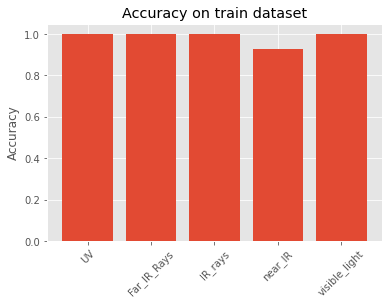

In [44]:
labls = ['UV','Far_IR_Rays','IR_rays',"near_IR",'visible_light']
plt.bar(labls,tr_scores)
plt.title('Accuracy on train dataset')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

In [45]:
# Finding the accuracy for each Wavelength Type
labls = ['UV', 'Visible', 'Near_IR', 'IR', 'Far_IR']
scores = []

for l in labls:
    test_x = x_test[x_test.wl_binned == l]
    test_y = y_test[x_test.wl_binned == l]

    scores.append(rf_model_wout_bin.score(test_x, test_y))

In [46]:
# Accuracy on the bases of Wavelength Category:
for i in range(len(labls)):
    print(labls[i],':', scores[i])

UV : 0.9915424739195231
Visible : 0.9800055320662268
Near_IR : 0.990897853691426
IR : 0.832433234421365
Far_IR : 0.950425698931224


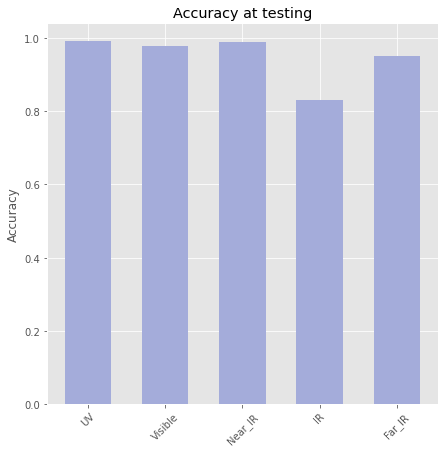

In [47]:
plt.figure(figsize = (7,7))
plt.bar(labls,scores, color= "#A4ACDA", width = 0.6)

plt.title('Accuracy at testing')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

In [48]:
# Test instances : UV
print(UV[10:12])
print('-'*90, end='\n\n')
print('Actual Class\n\n', UV_y[10:12])
print('-'*90, end='\n\n')
print('Predicted class\n\n', rf_model_wout_bin.predict(UV[10:12]))

              wl         n    k wl_binned
420743  0.390886  1.440377  0.0        UV
194988  0.398000  1.435420  0.0        UV
------------------------------------------------------------------------------------------

Actual Class

 420743             Cyclohexane
194988    polydimethylsiloxane
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['Cyclohexane' 'polydimethylsiloxane']


In [49]:
# Testing it with Visible
print(Visible[10:12])
print('-'*90, end='\n\n')
print('Actual Class\n\n', Visible_y[10:12])
print('-'*90, end='\n\n')
print('Predicted class\n\n', rf_model_wout_bin.predict(Visible[10:12]))

              wl         n    k wl_binned
173338  0.650840  1.622118  0.0   Visible
284043  0.731026  1.597595  0.0   Visible
------------------------------------------------------------------------------------------

Actual Class

 173338    polyetherimide
284043              urea
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['polyetherimide' 'urea']


In [50]:
# Test instance : Near_IR
print(Near_IR[10:12])
print('-'*90, end='\n\n')
print('Actual Class\n\n', Near_IR_y[10:12])
print('-'*90, end='\n\n')
print('Predicted class\n\n', rf_model_wout_bin.predict(Near_IR[10:12]))

             wl        n         k wl_binned
380835  1.37486  1.34813  0.000045   Near_IR
53071   1.45448  1.54740  0.000003   Near_IR
------------------------------------------------------------------------------------------

Actual Class

 380835             ethanol
53071     trichlorobenzene
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['ethanol' 'trichlorobenzene']


In [51]:
# Test instance : IR
print(IR[10:12])
print('-'*90, end='\n\n')
print('Actual Class\n\n', IR_y[10:15])
print('-'*90, end='\n\n')
print('Predicted class\n\n', rf_model_wout_bin.predict(IR[10:15]))

             wl        n         k wl_binned
316699  1.91433  1.39927  0.000047        IR
285617  2.30254  1.48737  0.000881        IR
------------------------------------------------------------------------------------------

Actual Class

 316699    dimethyl_methylphosphonate
285617                     oxathiane
250896       diisopropylaminoethanol
192087                      propanol
385838                        octane
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['dimethyl_methylphosphonate' 'oxathiane' 'diisopropylaminoethanol'
 'propanol' 'oxathiane']


In [52]:
# Test instance : Far_IR
print(Far_IR[10:12])
print('-'*90, end='\n\n')
print('Actual Class\n\n', Far_IR_y[10:15])
print('-'*90, end='\n\n')
print('Predicted class\n\n', rf_model_wout_bin.predict(Far_IR[10:15]))

             wl        n         k wl_binned
33560   14.7060  1.34900  0.000183    Far_IR
355776  13.0448  1.41103  0.002842    Far_IR
------------------------------------------------------------------------------------------

Actual Class

 33560                       pentane
355776                      toluene
109325    poly(methyl_methacrylate)
251244                      benzene
137966                     propanol
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['pentane' 'toluene' 'poly(methyl_methacrylate)' 'benzene' 'propanol']


**All of our predictions are correct**

In [53]:
y_pred = rf_model_wout_bin.predict(x_test)
print(y_pred)

['polycarbonate' 'benzene' 'polylactic_acid' ...
 'poly(N-isopropylacrylamide)' 'polycarbonate' 'cinnamaldehyde']


### Precision, Recall, F1-Score of this model

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                                         precision    recall  f1-score   support

(C2ClF3)n - polychlorotrifluoroethylene       0.00      0.00      0.00         8
           (C6H12)n - polymethylpentene       0.18      0.33      0.24         6
                              Acetylene       1.00      1.00      1.00        20
                            Cyclohexane       0.98      0.96      0.97      1362
                          Ethyl acetate       0.99      0.99      0.99      1265
                               Ethylene       1.00      1.00      1.00        26
                                Heptane       0.89      0.74      0.81        66
                                 Hexane       0.96      0.94      0.95      1295
                               Methanol       0.93      0.94      0.93      5726
                 Pentanol, amyl alcohol       1.00      0.80      0.89        54
                            acetic_acid       0.98      1.00      0.99       670
                           

## Confusion Matrix

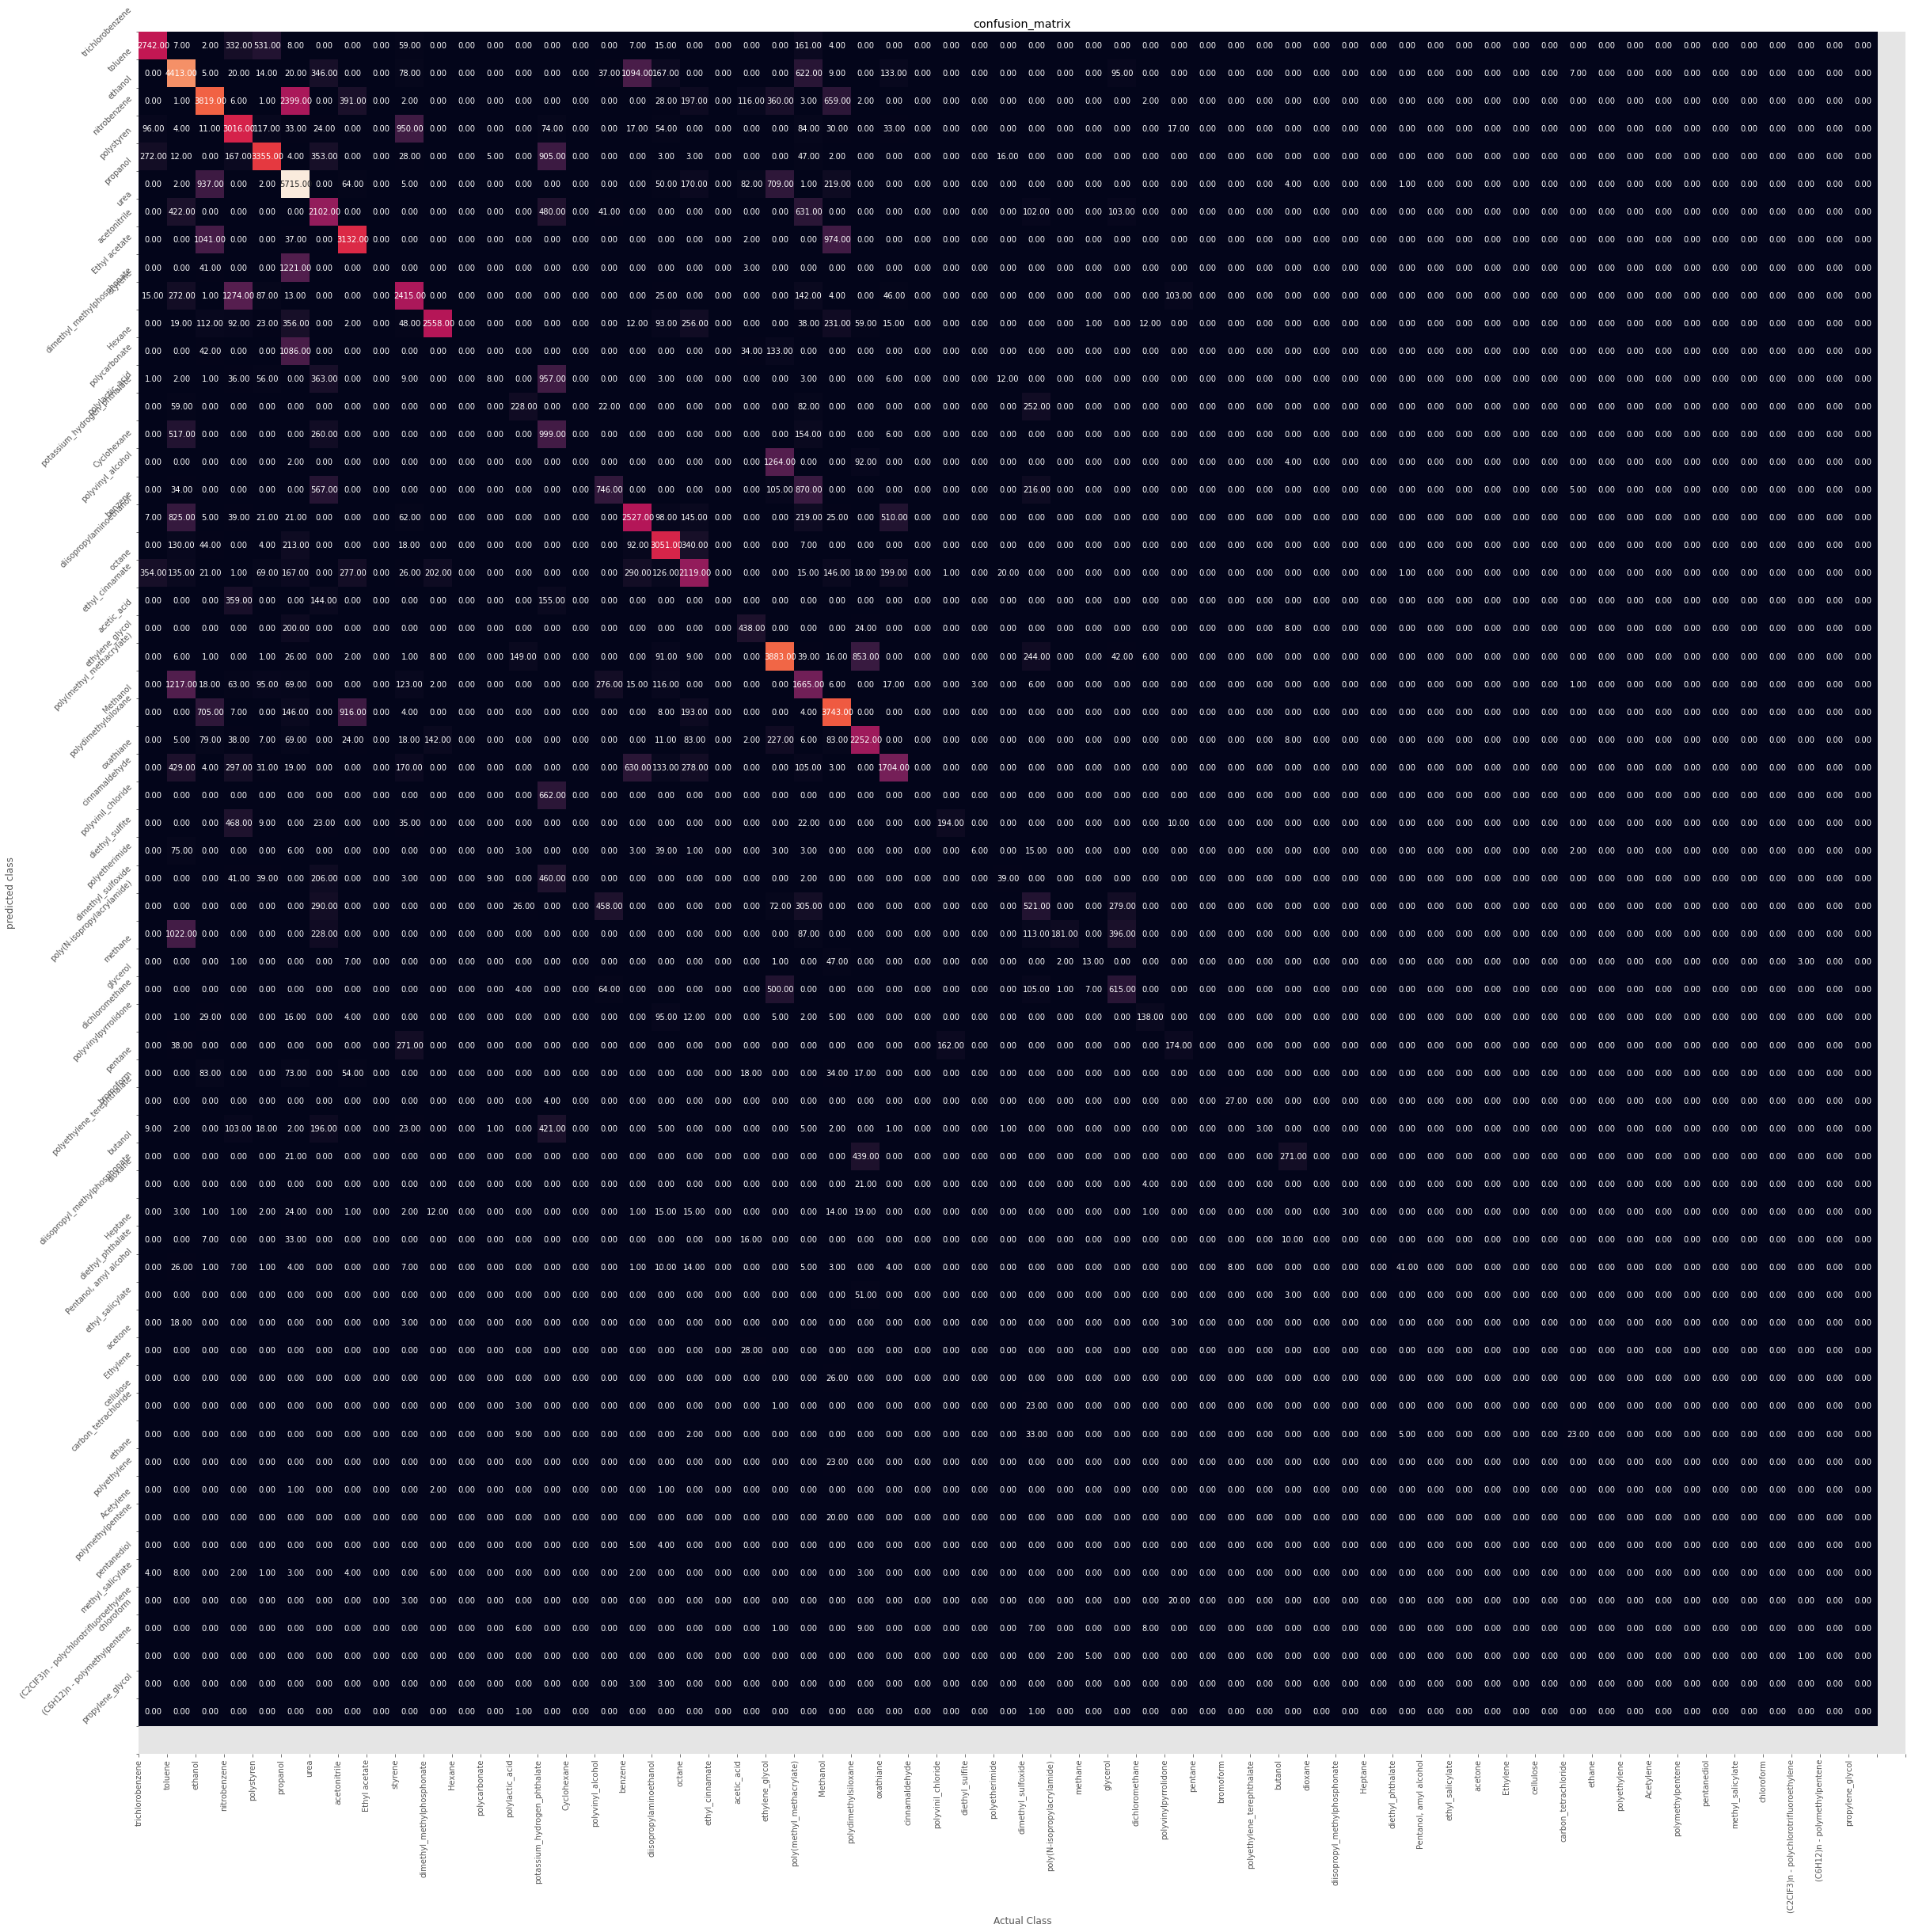

In [55]:
pred = rf_model.predict(x_test)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(40,40))
cm = confusion_matrix(y_test,pred,labels=list(df.book.unique()))
sns.heatmap(cm,annot=True,fmt='.2f',cbar=False)
plt.xticks(range(0,63),labels=list(df.book.unique()),rotation=90)
plt.yticks(range(0,63),labels=list(df.book.unique()),rotation=45)
plt.title('confusion_matrix')         #checking the confusion matrix
plt.xlabel('Actual Class')
plt.ylabel('predicted class')
plt.show()

ROUND-OFF

In [56]:
df.head()

,book,wl,n,k,wl_binned
0,trichlorobenzene,4.492320,1.543240,0.000041,Far_IR
1,toluene,1.293740,1.474590,0.000009,Near_IR
2,ethanol,4.328990,1.360250,0.000393,Far_IR
3,nitrobenzene,0.653261,1.545446,0.000000,Visible
4,polystyren,2.052170,1.553060,0.000069,IR


In [57]:
new_df = df.copy()
new_df.drop('wl_binned',axis=1,inplace=True)

In [58]:
#preprocessing and training pipeline with our own bins

numeric_transformer = Pipeline(steps=[
                                      ('scaler', StandardScaler())
                                      ])


preprocessor = ColumnTransformer(
    transformers=[
                  ('numeric', numeric_transformer, numeric_features),   #apply the transformation
                  ]) 

pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',RandomForestClassifier())
           ])

In [59]:
#split the data for training and testing

acc_tr = []
acc_ts = []

recall = []

round_place = [1,2,3,4,5]

for r in round_place:
  y = new_df['book']
  x = new_df.drop('book',axis=1).round(r)   #rounding off
  x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,random_state=42)
  rf_model = pipeline.fit(x_train,y_train)
  acc_tr.append(rf_model.score(x_train,y_train))
  acc_ts.append(rf_model.score(x_test,y_test))

  pred = rf_model.predict(x_test)

  recall.append(recall_score(y_test,pred,average='weighted'))

In [60]:
acc_tr,acc_ts,recall

([0.336582634059859,
  0.7950514797045981,
  0.952551225151085,
  0.9753951568948065,
  0.977275858144814],
 [0.32002479628415104,
  0.7644622530478766,
  0.9131321480230354,
  0.9330500327921873,
  0.933903528079995],
 [0.32002479628415104,
  0.7644622530478766,
  0.9131321480230354,
  0.9330500327921873,
  0.933903528079995])

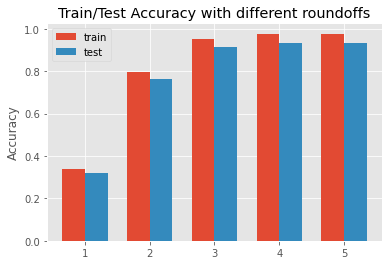

In [61]:
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
plt.title('Train/Test Accuracy with different roundoffs')
X_axis = np.arange(len(round_place))
ax.bar(X_axis - width/2,acc_tr,width,label='train')
ax.bar(X_axis + width/2,acc_ts,width,label='test')
plt.xticks(X_axis,round_place)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

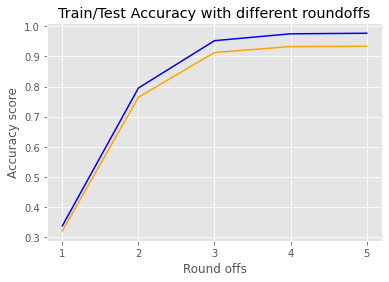

In [62]:
plt.title('Train/Test Accuracy with different roundoffs')
plt.plot(X_axis,acc_tr,color='b',label ='train')
plt.plot(X_axis,acc_ts,color='orange',label='test')
plt.xlabel('Round offs')
plt.ylabel('Accuracy score')
plt.xticks(range(len(round_place)),round_place)
plt.show()

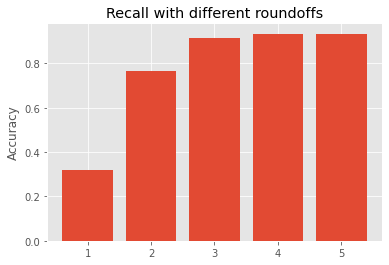

In [63]:
plt.bar(round_place,recall)
plt.title('Recall with different roundoffs')
plt.ylabel('Accuracy')
plt.show()